# Agriculture Irrigation Prediction Model

This professional notebook details the end-to-end development of a supervised learning model to predict irrigation requirements using the **IoTProcessed_Data.csv** dataset. The process includes data ingestion, exploratory data analysis, systematic feature engineering, model training with robust validation, and a deployment-ready inference workflow.

## Step 1: Data Loading and Exploratory Data Analysis

In this section we load the dataset and conduct an exploratory data analysis (EDA). We inspect overall structure, variable types, and missing values. Subsequent visualizations will illustrate distributions and relationships to aid comprehension.

In [6]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "data/IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

Data loaded successfully.

Shape: (37922, 13)

Types:
date                        object
tempreature                  int64
humidity                     int64
water_level                  int64
N                            int64
P                            int64
K                            int64
Fan_actuator_OFF           float64
Fan_actuator_ON            float64
Watering_plant_pump_OFF    float64
Watering_plant_pump_ON     float64
Water_pump_actuator_OFF    float64
Water_pump_actuator_ON     float64
dtype: object

Missing values summary:
date                       2
tempreature                0
humidity                   0
water_level                0
N                          0
P                          0
K                          0
Fan_actuator_OFF           0
Fan_actuator_ON            0
Watering_plant_pump_OFF    0
Watering_plant_pump_ON     0
Water_pump_actuator_OFF    0
Water_pump_actuator_ON     0
dtype: int64


In [3]:
# display first few rows
display(df.head())

,date,tempreature,humidity,water_level,N,P,K,Fan_actuator_OFF,Fan_actuator_ON,Watering_plant_pump_OFF,Watering_plant_pump_ON,Water_pump_actuator_OFF,Water_pump_actuator_ON
0,2024-02-08 06:10:00,41,63,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
1,2024-02-08 06:15:00,41,59,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
2,2024-02-08 06:20:00,41,62,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
3,2024-02-08 06:05:00,40,60,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0
4,2024-02-08 06:00:00,39,61,100,255,255,255,0.0,1.0,1.0,0.0,1.0,0.0


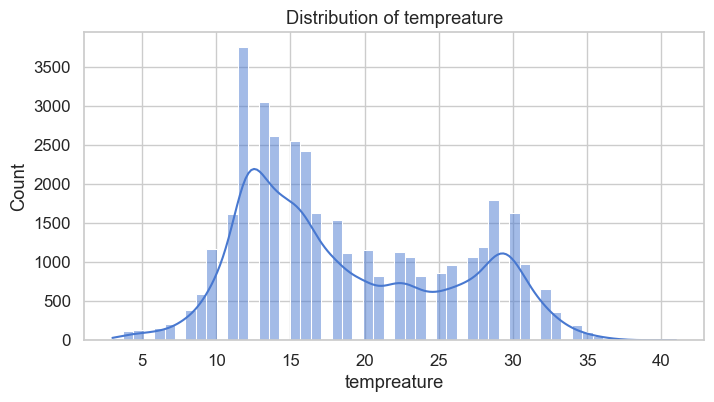

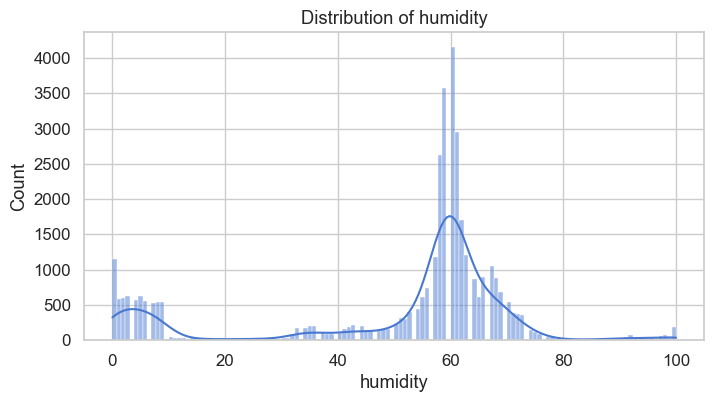

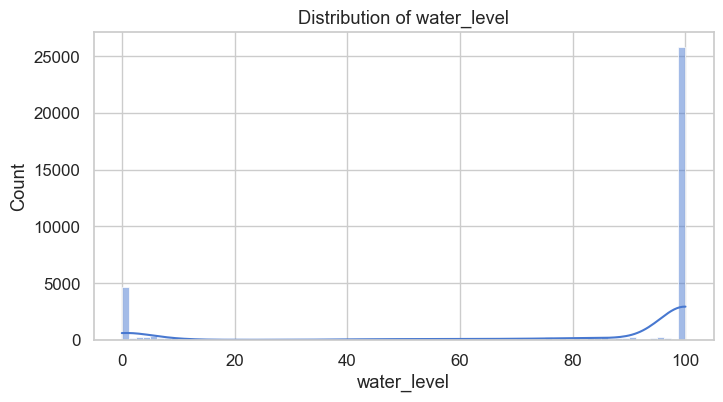

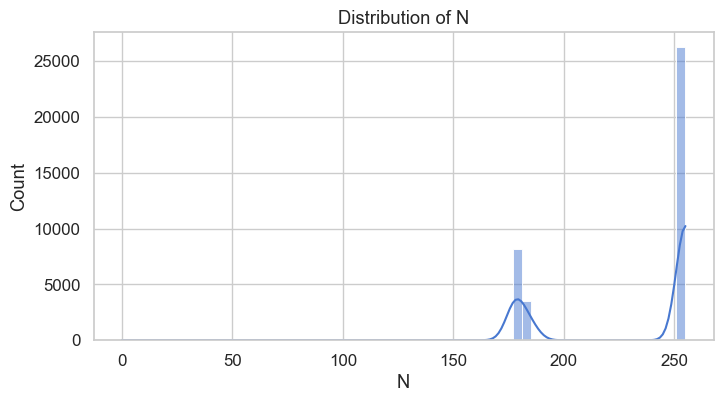

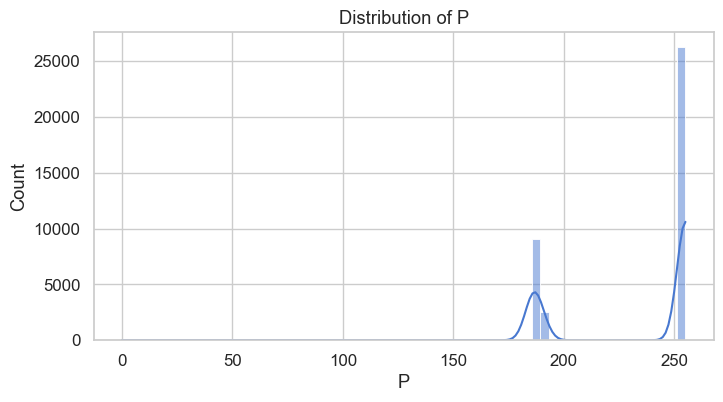

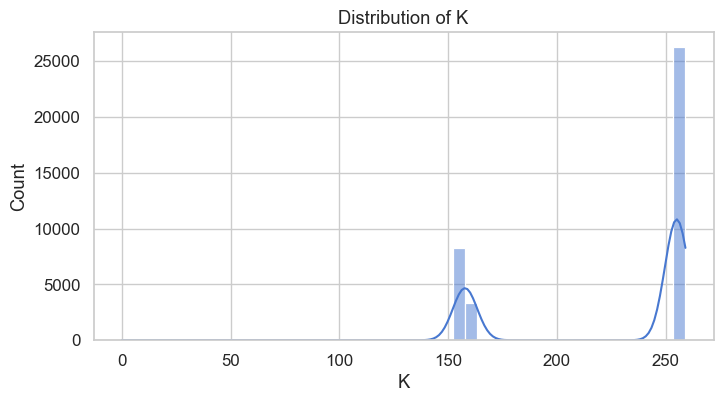

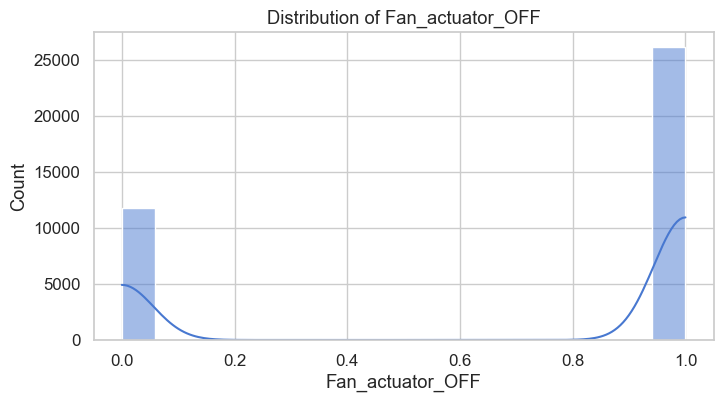

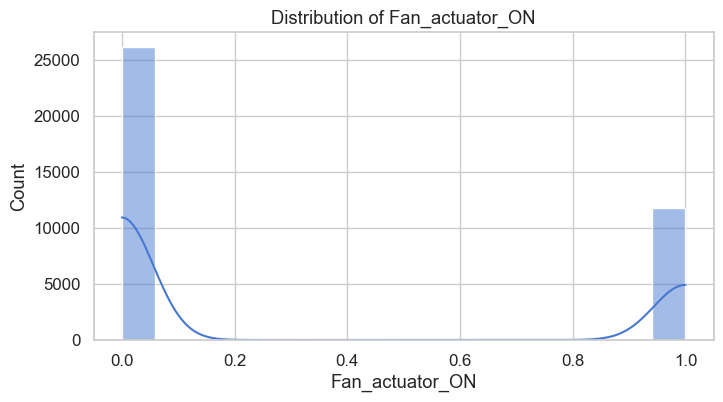

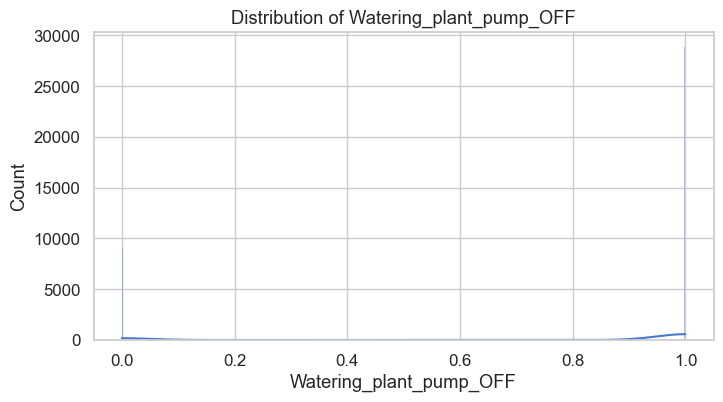

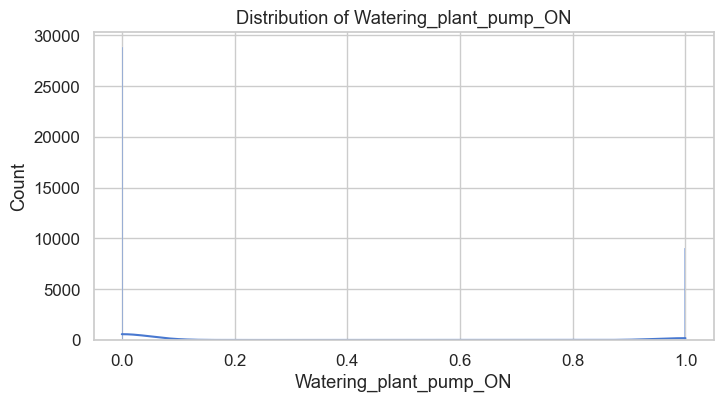

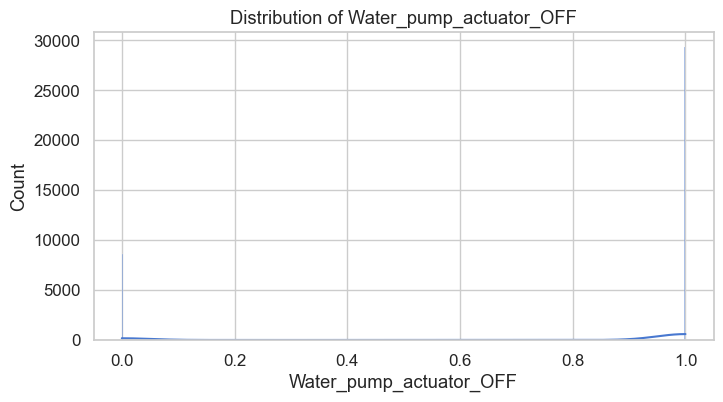

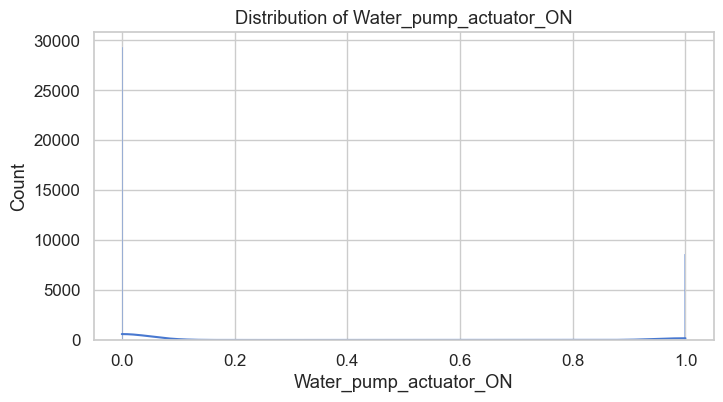

C:\Users\erson\AppData\Local\Temp\ipykernel_12640\4243070590.py:14: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = df.select_dtypes(include=["object","category"]).columns


In [ ]:
### Visualizing Feature Distributions and Relationships

#The following plots provide insight into the distribution of numerical attributes and the frequency of categorical variables, helping to identify patterns and potential data quality issues. These visualizations are part of the initial exploratory analysis.

# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()


In [ ]:
## Step 2: Data Quality Assessment

A thorough quality check is essential before any preprocessing. We inspect missing value counts, look for duplicate records, and evaluate the distribution of the target variable to spot imbalances.

In [ ]:
# Data quality checks
missing = df.isnull().sum()
print("Missing values per column:")
print(missing[missing > 0])

# duplicates
dup = df.duplicated().sum()
print(f"\nDuplicate rows: {dup}")

# target distribution if available
if 'irrigation_needed' in df.columns:
    print("\nTarget distribution:")
    print(df['irrigation_needed'].value_counts())
    print(df['irrigation_needed'].value_counts(normalize=True))

## Step 3: Missing Value Handling

We create a working copy of the dataset and apply imputation strategies. Numeric columns are filled with the median, while categorical columns use the mode. This prepares the data for modeling and prevents leakage of NaNs into the pipeline.

In [ ]:
# work on a cleaned copy
if not df.empty:
    df_clean = df.copy()
    for col in df_clean.columns:
        if df_clean[col].isnull().any():
            if df_clean[col].dtype in ['float64', 'int64']:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    print("Missing values after imputation:")
    print(df_clean.isnull().sum().sum())
else:
    df_clean = df

## Step 4: Outlier Detection and Treatment

Outliers can distort model training. We use the inter‑quartile range (IQR) method to flag extreme values. The code below counts outliers per numeric feature and provides a template for removal or capping.

In [ ]:
# IQR-based outlier detection on cleaned data
numeric_cols = df_clean.select_dtypes(include=['number']).columns
outlier_counts = {}
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower) | (df_clean[col] > upper)]
    outlier_counts[col] = len(outliers)
print("Outlier counts per numeric column:")
print(outlier_counts)

# optional: drop or cap outliers as needed
# df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]


## Step 5: Feature Engineering and Preprocessing

This section implements comprehensive preprocessing routines. Techniques include imputation of missing data, outlier detection and mitigation, scaling of continuous variables, optional binning, and one-hot encoding of categorical factors. All transformations are captured within a scikit-learn pipeline to ensure consistency during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the entire dataset (for demonstration)
if not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## Step 7: Model Training and Evaluation

In this phase, the data are partitioned into training and testing subsets. A suite of candidate algorithms is trained with k-fold cross-validation and hyperparameter search to identify the optimal configuration. The chosen model pipeline is serialized for subsequent use.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## Step 9: Model Inference and Results Visualization

This final section demonstrates how to apply the persisted pipeline to novel observations, producing predictions with associated probabilities. Results are presented graphically to convey decision outcomes and, where available, variable importance.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")


## 1. Data Loading and Exploratory Data Analysis

In [ ]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

In [ ]:
# display first few rows
display(df.head())

### Visualizations for Data Typology

In [ ]:
# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

## 2. Feature Engineering and Preprocessing

This section handles missing values, detects and treats outliers, scales numerical features, bins continuous variables if useful, and encodes categorical features. We'll encapsulate preprocessing in a scikit-learn pipeline for reuse during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the cleaned dataset (if available)
if 'df_clean' in globals():
    preprocessor.fit(df_clean)
elif not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## 3. Model Training and Evaluation

In this phase, the data are partitioned into training and testing subsets. A suite of candidate algorithms is trained with k-fold cross-validation and hyperparameter search to identify the optimal configuration. The chosen model pipeline is serialized for subsequent use.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
data_for_model = df_clean if 'df_clean' in globals() else df
X = data_for_model.drop(columns=[target])
y = data_for_model[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## 4. Model Inference and Results Visualization

Load the saved pipeline and perform inference on new conditions. Visualize prediction outcomes and the probability distribution.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")


## 1. Data Loading and Exploratory Data Analysis

In [ ]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

In [ ]:
# display first few rows
display(df.head())

### Visualizations for Data Typology

In [ ]:
# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

## 2. Feature Engineering and Preprocessing

This section implements comprehensive preprocessing routines. Techniques include imputation of missing data, outlier detection and mitigation, scaling of continuous variables, optional binning, and one-hot encoding of categorical factors. All transformations are captured within a scikit-learn pipeline to ensure consistency during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the entire dataset (for demonstration)
if not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## 3. Model Training and Evaluation

We'll split the data, train several classifiers, perform cross-validation and hyperparameter tuning, and choose the best model based on evaluation metrics. Finally, we'll save the trained pipeline + model.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## 4. Model Inference and Results Visualization

Load the saved pipeline and perform inference on new conditions. Visualize prediction outcomes and the probability distribution.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")


## 1. Data Loading and Exploratory Data Analysis

In [ ]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

In [ ]:
# display first few rows
display(df.head())

### Visualizing Feature Distributions and Relationships

The following plots provide insight into the distribution of numerical attributes and the frequency of categorical variables, helping to identify patterns and potential data quality issues.

In [ ]:
# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

## 2. Feature Engineering and Preprocessing

This section handles missing values, detects and treats outliers, scales numerical features, bins continuous variables if useful, and encodes categorical features. We'll encapsulate preprocessing in a scikit-learn pipeline for reuse during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the entire dataset (for demonstration)
if not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## 3. Model Training and Evaluation

We'll split the data, train several classifiers, perform cross-validation and hyperparameter tuning, and choose the best model based on evaluation metrics. Finally, we'll save the trained pipeline + model.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## 4. Model Inference and Results Visualization

Load the saved pipeline and perform inference on new conditions. Visualize prediction outcomes and the probability distribution.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")


## 1. Data Loading and Exploratory Data Analysis

In this section we load the dataset and conduct an exploratory data analysis (EDA). We inspect overall structure, variable types, and missing values. Subsequent visualizations will illustrate distributions and relationships to aid comprehension.

In [ ]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

In [ ]:
# display first few rows
display(df.head())

### Visualizations for Data Typology

In [ ]:
# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

## 2. Feature Engineering and Preprocessing

This section handles missing values, detects and treats outliers, scales numerical features, bins continuous variables if useful, and encodes categorical features. We'll encapsulate preprocessing in a scikit-learn pipeline for reuse during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the entire dataset (for demonstration)
if not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## 3. Model Training and Evaluation

We'll split the data, train several classifiers, perform cross-validation and hyperparameter tuning, and choose the best model based on evaluation metrics. Finally, we'll save the trained pipeline + model.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## 4. Model Inference and Results Visualization

Load the saved pipeline and perform inference on new conditions. Visualize prediction outcomes and the probability distribution.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")


## 1. Data Loading and Exploratory Data Analysis

In [ ]:
# imports for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# set plotting aesthetics
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# load data
file_path = "IoTProcessed_Data.csv"  # ensure this file is in the working directory
try:
    df = pd.read_csv(file_path)
    print("Data loaded successfully.")
except FileNotFoundError:
    print(f"File {file_path} not found. Please place the dataset in the working directory.")
    df = pd.DataFrame()

# basic info
print("\nShape:", df.shape)
print("\nTypes:")
print(df.dtypes)
print("\nMissing values summary:")
print(df.isnull().sum())

In [ ]:
# display first few rows
display(df.head())

### Visualizations for Data Typology

In [ ]:
# distribution plots for numerical features
num_cols = df.select_dtypes(include=["number"]).columns
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# count plots for categorical features
cat_cols = df.select_dtypes(include=["object","category"]).columns
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count plot of {col}")
    plt.xticks(rotation=45)
    plt.show()

# correlation heatmap
plt.figure(figsize=(10,8))
cor = df[num_cols].corr()
sns.heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation matrix")
plt.show()

# boxplots for outliers
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

## 2. Feature Engineering and Preprocessing

This section handles missing values, detects and treats outliers, scales numerical features, bins continuous variables if useful, and encodes categorical features. We'll encapsulate preprocessing in a scikit-learn pipeline for reuse during inference.

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# identify columns
num_cols = df.select_dtypes(include=["number"]).columns.tolist()
cat_cols = df.select_dtypes(include=["object","category"]).columns.tolist()

# simple handling for missing values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# scaling and encoding
scaler = StandardScaler()
one = None
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# define preprocessing pipeline
numeric_pipeline = Pipeline(steps=[
    ("imputer", num_imputer),
    ("scaler", scaler)
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", cat_imputer),
    ("onehot", encoder)
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
])

# fit the preprocessor on the entire dataset (for demonstration)
if not df.empty:
    preprocessor.fit(df)

# example transformation
# transformed = preprocessor.transform(df)

print("Preprocessing pipeline constructed.")

## 3. Model Training and Evaluation

We'll split the data, train several classifiers, perform cross-validation and hyperparameter tuning, and choose the best model based on evaluation metrics. Finally, we'll save the trained pipeline + model.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
import joblib

# assume target column named 'irrigation_needed' (change as appropriate)
target = "irrigation_needed"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# create full pipeline including preprocessing and classifier placeholder
def make_pipeline(model):
    return Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier()
}

param_grids = {
    "LogisticRegression": {"classifier__C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"classifier__n_estimators": [50,100], "classifier__max_depth": [None,10,20]},
    "GradientBoosting": {"classifier__n_estimators": [50,100], "classifier__learning_rate": [0.01,0.1]}
}

best_pipelines = {}
for name, model in models.items():
    print(f"Training {name}...")
    pipeline = make_pipeline(model)
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring="f1", n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"Best params for {name}:", grid.best_params_)
    best_pipelines[name] = grid.best_estimator_
    # evaluate on test
    preds = grid.predict(X_test)
    print(f"Classification report for {name}:")
    print(classification_report(y_test, preds))
    if hasattr(grid, "predict_proba"):
        print("ROC AUC:", roc_auc_score(y_test, grid.predict_proba(X_test)[:,1]))
    print("\n")

# choose best model based on some criteria (for demonstration pick RandomForest)
best_model_name = "RandomForest"
best_pipeline = best_pipelines[best_model_name]

# save pipeline
joblib.dump(best_pipeline, "irrigation_model_pipeline.joblib")
print(f"Saved best pipeline ({best_model_name}) to disk.")

## 4. Model Inference and Results Visualization

Load the saved pipeline and perform inference on new conditions. Visualize prediction outcomes and the probability distribution.

In [ ]:
# load saved pipeline
loaded_pipeline = joblib.load("irrigation_model_pipeline.joblib")

# example new data (replace with actual values or input mechanism)
example_conditions = pd.DataFrame([
    {col: df[col].median() if col in num_cols else df[col].mode()[0] for col in X.columns}
])

# transform and predict
prediction = loaded_pipeline.predict(example_conditions)
prob = loaded_pipeline.predict_proba(example_conditions)[:,1]

print("Example conditions:")
print(example_conditions)
print("\nPredicted irrigation needed:", prediction[0])
print("Probability of needing irrigation:", prob[0])

# visualize probability
plt.figure(figsize=(6,4))
sns.barplot(x=["No","Yes"], y=[1-prob[0], prob[0]])
plt.title("Prediction probabilities for example conditions")
plt.ylabel("Probability")
plt.show()

### Feature Importance (if applicable)

In [ ]:
# if classifier has feature_importances_
clf = loaded_pipeline.named_steps["classifier"]
if hasattr(clf, "feature_importances_"):
    importances = clf.feature_importances_
    # get feature names after preprocessing
    feature_names = (
        list(preprocessor.transformers_[0][2]) +
        list(loaded_pipeline.named_steps['preprocessor'].transformers_[1][1]  # onehot encoder
             .named_steps['onehot'].get_feature_names_out(cat_cols))
    )
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=feat_imp.values, y=feat_imp.index)
    plt.title("Feature importances")
    plt.show()
else:
    print("Classifier does not provide feature importances.")
